### Setup inicial do projeto

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator # type: ignore

# Define as dimensões para as quais todas as imagens serão redimensionadas
IMG_HEIGHT = 150
IMG_WIDTH = 150

# Tamanho de cada batch
BATCH_SIZE = 32

TRAIN_DIR = '../processed_data/dataset_1_split/train'
VALIDATION_DIR = '../processed_data/dataset_1_split/validation'


print("Configurando o gerador de dados de TREINO...")
# Gerador de dados para o conjunto de TREINO (com Data Augmentation)
train_datagen = ImageDataGenerator(
    rescale=1./255,             # Normaliza os pixels para o intervalo [0, 1]
    rotation_range=40,          # Rotaciona a imagem em até 40 graus
    width_shift_range=0.2,      # Desloca a largura em até 20%
    height_shift_range=0.2,     # Desloca a altura em até 20%
    shear_range=0.2,            # Aplica cisalhamento
    zoom_range=0.2,             # Aplica zoom de até 20%
    horizontal_flip=True,       # Inverte a imagem horizontalmente
    fill_mode='nearest'         # Preenche pixels novos com o valor mais próximo
)


print("Configurando o gerador de dados de VALIDAÇÃO...")
# Gerador de dados para o conjunto de VALIDAÇÃO (APENAS normalização)
validation_datagen = ImageDataGenerator(
    rescale=1./255
)


# Carrega as imagens de treino a partir do diretório
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True               # Embaralha os dados de treino
)


# Carrega as imagens de validação a partir do diretório
validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False              
)

Configurando o gerador de dados de TREINO...
Configurando o gerador de dados de VALIDAÇÃO...
Found 1600 images belonging to 16 classes.
Found 411 images belonging to 16 classes.


### Criação da CNN

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models # type: ignore

# --- ARQUITETURA DA CNN ---

# Inicia um modelo sequencial, onde as camadas são empilhadas uma após a outra
model = models.Sequential(name='CNN_Alimentos_Parte1')

# --- BLOCO 1 ---
# Camada Convolucional inicial para aprender 32 padrões (filtros) simples.
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3), padding='same', name='conv1_1'))
# Camada de Pooling para reduzir as dimensões pela metade e reter as características mais fortes.
model.add(layers.MaxPooling2D((2, 2), name='pool1'))

# --- BLOCO 2 ---
# 64 filtros para que a rede possa aprender padrões mais complexos
# a partir das características simples da camada anterior.
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same' ,name='conv2_1'))
model.add(layers.MaxPooling2D((2, 2), name='pool2'))

# --- BLOCO 3 ---
# Mais uma camada com 128 filtros para aprender abstrações de nível ainda mais alto.
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='conv3_1'))
model.add(layers.MaxPooling2D((2, 2), name='pool3'))

# --- CLASSIFICADOR (MLP) ---

# 1. Achatamos (Flatten) o mapa de características 3D para um vetor 1D
# para que ele possa ser processado pelas camadas Densas.
model.add(layers.Flatten(name='flatten'))

# 2. Camada Densa (Totalmente Conectada) com 256 neurônios para aprender
# a combinar todas as características extraídas.
model.add(layers.Dense(256, activation='relu', name='dense1'))

# 3. Camada de Dropout para combater o overfitting. Ele "desliga" aleatoriamente
# 50% dos neurônios durante o treino para forçar a rede a não depender de um
# único caminho, tornando-a mais robusta.
model.add(layers.Dropout(0.5, name='dropout'))

# 4. Camada de Saída. O número de neurônios deve ser igual ao número de classes.
# A ativação 'softmax' transforma a saída em probabilidades para cada classe.
model.add(layers.Dense(16, activation='softmax', name='output'))

# --- FIM DA ARQUITETURA ---

# Imprime um resumo legível da sua arquitetura
model.summary()

Model: "CNN_Alimentos_Parte1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1_1 (Conv2D)                │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2_1 (Conv2D)                │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3_1 (Conv2D)                │ (None, 37, 37, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool3 (MaxPooling2D)            │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 41472)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 256)            │    10,617,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 16)             │         4,112 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,714,448 (40.87 MB)

 Trainable params: 10,714,448 (40.87 MB)

 Non-trainable params: 0 (0.00 B)

### Compilação do modelo proposto

In [ ]:
print("Compilando o modelo...")
model.compile(
    optimizer='sgd',                    # Otimizador eficiente e padrão
    loss='categorical_crossentropy',    # Função de perda para classificação multiclasse
    metrics=['accuracy']                # Métrica para monitorar o desempenho
)
print("Modelo compilado com sucesso!")

Compilando o modelo...
Modelo compilado com sucesso!


### Treinamento do modelo

In [ ]:
# Defina o número de épocas (quantas vezes o modelo verá o dataset de treino inteiro)
EPOCHS = 20 

print(f"Iniciando o treinamento por {EPOCHS} épocas...")

# O objeto 'history' armazena os valores de perda e métricas de cada época.
history = model.fit(
    train_generator,          # Fornece os lotes de dados de treino (com augmentation)
    epochs=EPOCHS,            # Número de ciclos de treinamento
    validation_data=validation_generator, # Fornece os dados de validação para teste ao fim de cada época
    verbose=1                 # Mostra uma barra de progresso
)

print("Treinamento concluído!")

Iniciando o treinamento por 20 épocas...
Epoch 1/20


2025-06-16 15:35:01.976454: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 92160000 exceeds 10% of free system memory.
2025-06-16 15:35:02.816988: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 92160000 exceeds 10% of free system memory.


50/50 ━━━━━━━━━━━━━━━━━━━━ 89s 2s/step - accuracy: 0.1036 - loss: 2.8237 - val_accuracy: 0.2214 - val_loss: 2.3659
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 95s 2s/step - accuracy: 0.1744 - loss: 2.4424 - val_accuracy: 0.3066 - val_loss: 2.0039
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.2668 - loss: 2.1153 - val_accuracy: 0.3723 - val_loss: 1.6383
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - accuracy: 0.3780 - loss: 1.8071 - val_accuracy: 0.5328 - val_loss: 1.3122
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - accuracy: 0.4860 - loss: 1.4702 - val_accuracy: 0.6156 - val_loss: 1.1588
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.5556 - loss: 1.2868 - val_accuracy: 0.6934 - val_loss: 0.7892
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - accuracy: 0.6572 - loss: 0.9766 - val_accuracy: 0.7348 - val_loss: 0.8699
Epoch 8/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - accuracy: 0.6401 - loss: 0.9852 - val_accuracy: 0.8151 - val_loss: 0.5157
Epo

### Análise do treinamento do modelo

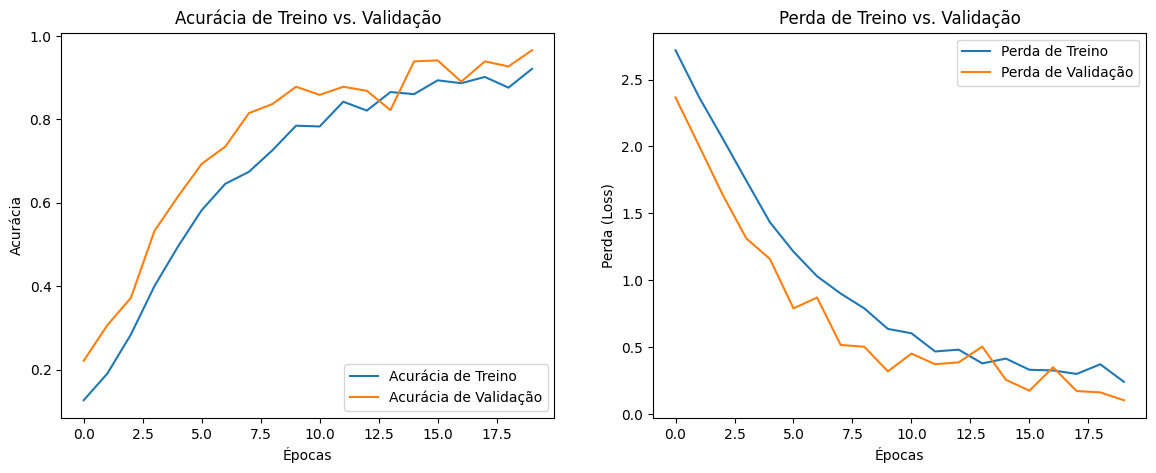

In [14]:
import matplotlib.pyplot as plt

# Pega os resultados do histórico de treinamento
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Define o range de épocas
epochs_range = range(len(acc))

# Plota a Acurácia de Treino e Validação
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Acurácia de Treino')
plt.plot(epochs_range, val_acc, label='Acurácia de Validação')
plt.legend(loc='lower right')
plt.title('Acurácia de Treino vs. Validação')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')

# Plota a Perda de Treino e Validação
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Perda de Treino')
plt.plot(epochs_range, val_loss, label='Perda de Validação')
plt.legend(loc='upper right')
plt.title('Perda de Treino vs. Validação')
plt.xlabel('Épocas')
plt.ylabel('Perda (Loss)')
plt.show()

### Salvando o primeiro modelo

In [ ]:
# Salva o modelo inteiro (arquitetura + pesos)
model.save('modelo_base.h5')